<a href="https://colab.research.google.com/github/greygrease/Project-Malaria-Diagnosis-CNN/blob/main/Malaria_FCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plots
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import io
import os
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorboard.plugins.hparams import api as hp
from google.colab import drive

## Get and Prepare Data

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info = True, as_supervised = True, split = ['train'], shuffle_files = True)

In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear i

In [ ]:
for data in dataset[0].take(1):
  print(data)

(<tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [ ]:
def splits(dataset, train_ratio, val_ratio, test_ratio):
  dataset_size = len(dataset)

  train_data = dataset.take(int(train_ratio * dataset_size))
  train_val = dataset.skip(int(train_ratio * dataset_size))

  val_data = train_val.take(int(val_ratio * dataset_size))
  test_data = train_val.skip(int(val_ratio * dataset_size))
  return train_data, val_data, test_data

In [ ]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )

In [ ]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
list(train_dataset.as_numpy_iterator())[0]

(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 1)

## Dataset Visualization

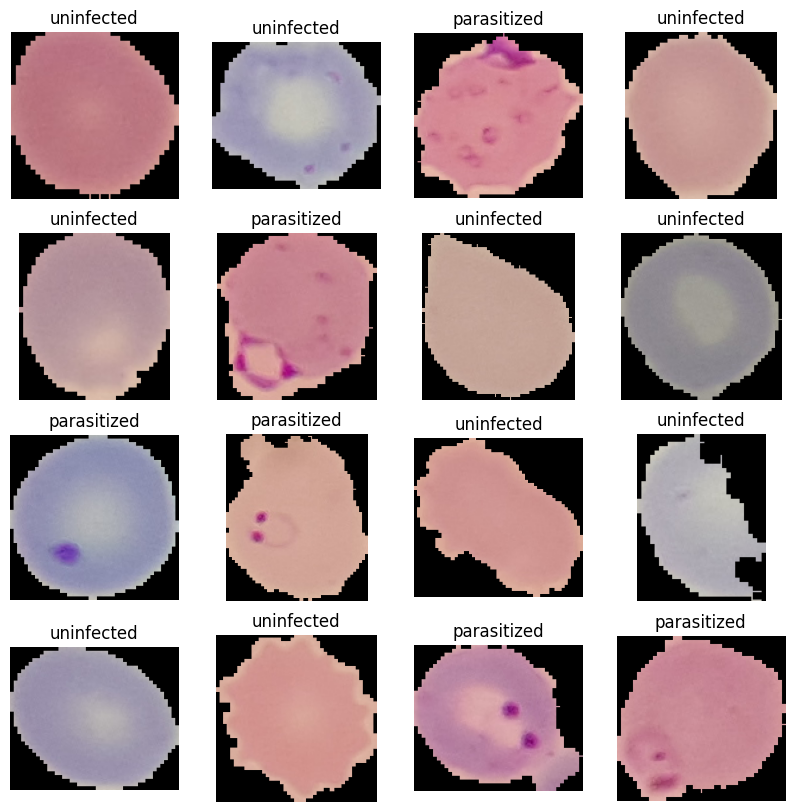

In [ ]:
plt.figure(figsize = (10, 10))
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [ ]:
dataset_info.features['label'].int2str(label)

'parasitized'

## Dataset Preprocessing

In [ ]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [ ]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [ ]:
for im, la in train_dataset.take(1):
  print(im)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32)


In [ ]:
tf.reduce_max(im), tf.reduce_min(im)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.8751619>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)

In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Modelling

### Lenet Model 1

In [ ]:
IM_SIZE = 224
model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    Conv2D(6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(2, strides = 2),
    Conv2D(16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(2, strides = 2),
    Flatten(),
    Dense(100, activation = 'relu'),
    BatchNormalization(),
    Dense(10, activation = 'relu'),
    BatchNormalization(),
    Dense(1, activation = 'sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_50 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 111, 111, 6)      0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_51 (Bat  (None, 109, 109, 16)     64        
 chNormalization)                                                
                                                      

In [ ]:
y_true = [0., 1., 1., 0.]
y_pred = [0.1, 0.9, 0.5, 0.4]
bce = tf.keras.losses.BinaryCrossentropy(from_logits = True)
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6181607>

In [ ]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
              metrics = ['accuracy'])

history = model.fit(train_dataset, epochs = 10, validation_data = val_dataset)

Epoch 1/10
689/689 [==============================] - 59s 79ms/step - loss: 0.3164 - accuracy: 0.8755 - val_loss: 0.1783 - val_accuracy: 0.9343
Epoch 2/10
689/689 [==============================] - 56s 81ms/step - loss: 0.2026 - accuracy: 0.9336 - val_loss: 0.1861 - val_accuracy: 0.9434
Epoch 3/10
689/689 [==============================] - 60s 87ms/step - loss: 0.1863 - accuracy: 0.9370 - val_loss: 0.4176 - val_accuracy: 0.9100
Epoch 4/10
689/689 [==============================] - 54s 79ms/step - loss: 0.1693 - accuracy: 0.9448 - val_loss: 1.2099 - val_accuracy: 0.5103
Epoch 5/10
689/689 [==============================] - 55s 79ms/step - loss: 0.1642 - accuracy: 0.9457 - val_loss: 0.1870 - val_accuracy: 0.9390
Epoch 6/10
689/689 [==============================] - 60s 87ms/step - loss: 0.1682 - accuracy: 0.9443 - val_loss: 0.3875 - val_accuracy: 0.7764
Epoch 7/10
689/689 [==============================] - 54s 79ms/step - loss: 0.1581 - accuracy: 0.9486 - val_loss: 0.2125 - val_accuracy:

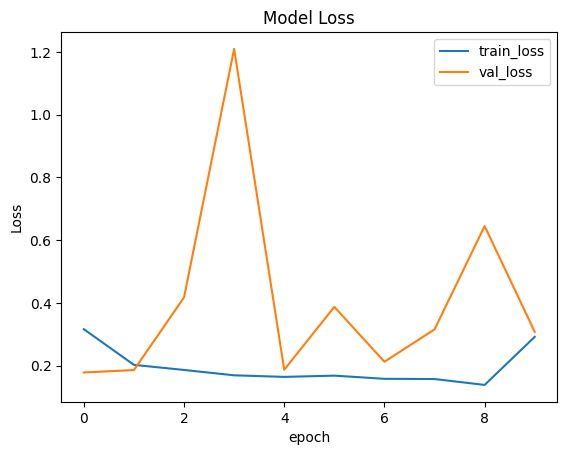

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
model.evaluate(test_dataset)

87/87 [==============================] - 15s 34ms/step - loss: 0.2194 - accuracy: 0.9340


[0.2194431722164154, 0.933986246585846]

In [ ]:
model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 13s 13s/step


0.7063237

In [ ]:
model.predict(test_dataset.take(1))[0]

1/1 [==============================] - 15s 15s/step


array([0.00395647], dtype=float32)

In [ ]:
model.predict(test_dataset.take(1))

1/1 [==============================] - 14s 14s/step


array([[8.8485432e-01],
       [1.0949637e-01],
       [6.3470602e-02],
       [2.9623609e-02],
       [9.8650277e-02],
       [3.9564651e-03],
       [4.8957121e-01],
       [8.9695603e-01],
       [8.9971982e-03],
       [9.1672045e-01],
       [8.0176294e-01],
       [1.9741114e-03],
       [5.1225617e-04],
       [8.7833577e-01],
       [1.5015025e-03],
       [4.1368392e-01],
       [7.0632368e-01],
       [7.9575563e-03],
       [4.1886815e-03],
       [8.4234303e-01],
       [3.4536783e-02],
       [7.3819995e-01],
       [2.6649120e-03],
       [7.9711843e-01],
       [3.0596997e-03],
       [7.2172272e-01],
       [4.7255456e-04],
       [9.2537481e-01],
       [8.6136651e-01],
       [6.5223021e-03],
       [8.1420922e-01],
       [1.7746279e-03]], dtype=float32)

In [ ]:
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

1/1 [==============================] - 0s 29ms/step


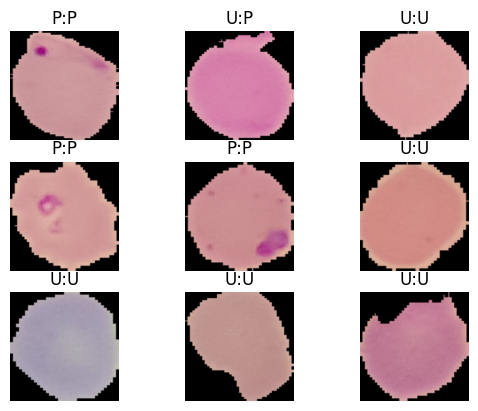

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model.predict(image)[0][0])))

  plt.axis('off')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_17 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_18 (Bat  (None, 109, 109, 16)     64        
 chNormalization)                                                
                                                      

### Lenet Model 2 (Functional)

In [ ]:
inputs = Input(shape = (IM_SIZE, IM_SIZE, 3))
x = Conv2D(6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(inputs)
x = BatchNormalization()(x)
x = MaxPool2D(2, strides = 2)(x)
x = Conv2D(16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(2, strides = 2)(x)
x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation ='relu')(x)
x = BatchNormalization()(x)
outputs = Dense(1, activation = 'sigmoid')(x)
lenet_model = Model(inputs = inputs, outputs = outputs, name = 'LeNet_Model')

In [ ]:
lenet_model.summary()

Model: "LeNet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_45 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_61 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 111, 111, 6)      0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_62 (Bat  (None, 109, 109, 16)     

In [ ]:
lenet_model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
              metrics = ['accuracy'])

history = lenet_model.fit(train_dataset, epochs = 3, validation_data = val_dataset)

Epoch 1/3
689/689 [==============================] - 107s 151ms/step - loss: 0.2904 - accuracy: 0.8869 - val_loss: 0.5506 - val_accuracy: 0.8838
Epoch 2/3
689/689 [==============================] - 48s 69ms/step - loss: 0.2210 - accuracy: 0.9260 - val_loss: 0.7960 - val_accuracy: 0.7397
Epoch 3/3
689/689 [==============================] - 53s 76ms/step - loss: 0.2151 - accuracy: 0.9262 - val_loss: 0.3487 - val_accuracy: 0.8817


In [ ]:
lenet_model.evaluate(test_dataset)

87/87 [==============================] - 16s 35ms/step - loss: 0.3437 - accuracy: 0.8799


[0.3437158763408661, 0.8799419403076172]

In [ ]:
lenet_model.predict(test_dataset.take(1))[0]

1/1 [==============================] - 12s 12s/step


array([0.607949], dtype=float32)

### LeNet Model 3 (Create Feature Extractor- Functioanl)

In [ ]:
func_inputs = Input(shape = (IM_SIZE, IM_SIZE, 3))
x = Conv2D(6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(func_inputs)
x = BatchNormalization()(x)
x = MaxPool2D(2, strides = 2)(x)
x = Conv2D(16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(2, strides = 2)(x)
feature_extractor_model = Model(func_inputs, output, name = "Feature_Extractor")
# feature_extractor_model.summary()

In [ ]:
inputs = Input(shape = (IM_SIZE, IM_SIZE, 3))
x = feature_extractor_model(inputs)
x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation ='relu')(x)
x = BatchNormalization()(x)
outputs = Dense(1, activation = 'sigmoid')(x)
lenet_model_2 = Model(inputs = inputs, outputs = outputs, name = 'LeNet_Model')

In [ ]:
lenet_model_2.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
              metrics = ['accuracy'])

history = lenet_model_2.fit(train_dataset, epochs = 3, validation_data = val_dataset)

Epoch 1/3
689/689 [==============================] - 50s 66ms/step - loss: 0.2186 - accuracy: 0.9291 - val_loss: 0.1957 - val_accuracy: 0.9314
Epoch 2/3
689/689 [==============================] - 54s 79ms/step - loss: 0.1722 - accuracy: 0.9477 - val_loss: 0.2668 - val_accuracy: 0.9397
Epoch 3/3
689/689 [==============================] - 52s 76ms/step - loss: 0.1517 - accuracy: 0.9519 - val_loss: 0.2856 - val_accuracy: 0.9321


In [ ]:
lenet_model.evaluate(test_dataset)

87/87 [==============================] - 18s 32ms/step - loss: 0.3430 - accuracy: 0.8807


[0.34299927949905396, 0.8806673884391785]

In [ ]:
lenet_model.predict(test_dataset.take(1))[0]

1/1 [==============================] - 12s 12s/step


array([0.6998626], dtype=float32)

### LeNet Model 4 (Create Feature Extractor - Seq)

In [ ]:
feature_extractor_seq_model = model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    Conv2D(6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(2, strides = 2),
    Conv2D(16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(2, strides = 2)])

In [ ]:
inputs = Input(shape = (IM_SIZE, IM_SIZE, 3))
x = feature_extractor_seq_model(inputs)
x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation ='relu')(x)
x = BatchNormalization()(x)
outputs = Dense(1, activation = 'sigmoid')(x)
lenet_model_3 = Model(inputs = inputs, outputs = outputs, name = 'LeNet_Model')

In [ ]:
lenet_model_3.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
              metrics = ['accuracy'])

history = lenet_model_3.fit(train_dataset, epochs = 3, validation_data = val_dataset)

Epoch 1/3
689/689 [==============================] - 57s 78ms/step - loss: 0.3591 - accuracy: 0.8396 - val_loss: 2.2151 - val_accuracy: 0.4947
Epoch 2/3
689/689 [==============================] - 49s 71ms/step - loss: 0.2127 - accuracy: 0.9287 - val_loss: 0.6988 - val_accuracy: 0.5608
Epoch 3/3
689/689 [==============================] - 55s 79ms/step - loss: 0.1837 - accuracy: 0.9394 - val_loss: 0.2851 - val_accuracy: 0.9339


In [ ]:
lenet_model_3.evaluate(test_dataset)

87/87 [==============================] - 18s 33ms/step - loss: 0.2958 - accuracy: 0.9253


[0.29582324624061584, 0.9252811074256897]

In [ ]:
lenet_model_3.predict(test_dataset.take(1))[0]

1/1 [==============================] - 13s 13s/step


array([0.5551696], dtype=float32)

## Model SubClassing

In [ ]:
func_inputs = Input(shape = (IM_SIZE, IM_SIZE, 3))
x = Conv2D(6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(func_inputs)
x = BatchNormalization()(x)
x = MaxPool2D(2, strides = 2)(x)
x = Conv2D(16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(2, strides = 2)(x)
feature_extractor_model = Model(func_inputs, output, name = "Feature_Extractor")
# feature_extractor_model.summary()

In [ ]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor, self).__init__()
    self.conv_1 =  Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size = pool_size , strides = 2*strides)
    self.conv_2 =  Conv2D(filters = 2*filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size = pool_size, strides = 2*strides)

  def call(self, x, training):
    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x


In [ ]:
feature_sub_classed = FeatureExtractor(filters = 8,
                                     kernel_size = 1,
                                     strides = 1,
                                     padding = 'valid',
                                     activation = 'relu',
                                     pool_size = 2)

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_sub_classed(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor_2 (Featur  (None, 56, 56, 12)       180       
 eExtractor)                                                     
                                                                 
 flatten (Flatten)           (None, 37632)             0         
                                                                 
 dense (Dense)               (None, 100)               3763300   
                                                                 
 batch_normalization_7 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 10)                

In [ ]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(filters = 8,
                                     kernel_size = 3,
                                     strides = 1,
                                     padding = 'valid',
                                     activation = 'relu',
                                     pool_size = 2)
    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation = 'relu')
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = 'relu')
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = 'sigmoid')


  def call(self, x, training):
    x = self.feature_extractor(x)
    x = self.flatten(x)

    x = self.dense_1(x)
    x = self.batch_1(x)

    x = self.dense_2(x)
    x = self.batch_2(x)

    x = self.dense_3(x)

    return x

In [ ]:
lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1,224,224,3]))
lenet_sub_classed.summary()

Model: "lenet_model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_11 (Featu  multiple                 1488      
 reExtractor)                                                    
                                                                 
 flatten_8 (Flatten)         multiple                  0         
                                                                 
 dense_24 (Dense)            multiple                  4665700   
                                                                 
 batch_normalization_48 (Bat  multiple                 400       
 chNormalization)                                                
                                                                 
 dense_25 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_49 (Bat  multiple               

In [ ]:
lenet_sub_classed.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
              metrics = ['accuracy'])

history = lenet_sub_classed.fit(train_dataset, epochs = 3, validation_data = val_dataset)

Epoch 1/3
689/689 [==============================] - 53s 67ms/step - loss: 0.3226 - accuracy: 0.8666 - val_loss: 0.3385 - val_accuracy: 0.8642
Epoch 2/3
689/689 [==============================] - 45s 65ms/step - loss: 0.2104 - accuracy: 0.9281 - val_loss: 0.1912 - val_accuracy: 0.9310
Epoch 3/3
689/689 [==============================] - 59s 86ms/step - loss: 0.1988 - accuracy: 0.9328 - val_loss: 0.1924 - val_accuracy: 0.9376
